In [0]:
import re
import glob
import zipfile
import smart_open
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
EMBEDDING_DIM = 50
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300

# Data Loading

In [3]:
!curl -OL http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  16.9M      0  0:00:04  0:00:04 --:--:-- 16.9M


In [0]:
def preprocess_text(sen, tags_re=re.compile(r'<[^>]+>')):
    '''Removing html tags'''
    sentence = tags_re.sub('', sen)
    return sentence

In [0]:
def get_data(train=True, transform=preprocess_text):
  reviews, labels = [], []
  mode = 'train' if train else 'test'

  for filename in glob.glob('aclImdb/%s/pos/*.txt' % mode):
    with open(filename, 'r') as f:
      review = f.readlines()[0]
      reviews.append(transform(review))
      labels.append(1)

  for filename in glob.glob('aclImdb/%s/neg/*.txt' % mode):
    with open(filename, 'r') as f:
      review = f.readlines()[0]
      reviews.append(transform(review))
      labels.append(0)

  return reviews, np.array(labels)

In [0]:
reviews_train, y_train = get_data()

In [7]:
reviews_train[-5000], y_train[-5000]

("I tried to like this slasher, like I try to enjoy all slasher films. I mean mindless slaying mixed with a little nudity and some suspense, how can you go wrong. But Unhinged I think is an example of that formula going wrong. The main issue is the horrible acting of the main three girls that landed up in the house. It was as if they were under sedation, and it stopped me from ever getting interested in their plight. The film aims for suspense and creepiness but the by the numbers direction saps it of those, and leaves the movie pretty dull. It's a shame, because if the movie was better executed, it would have have been ace. The story and characters are pretty creepy and there are some dark and bizarrely humorous moments of interaction between the mother, the girls, and the daughter in the old house. There's some good nudity, and occasional splashy bloodletting, just not enough to give the film the kick it needed. The finale is pretty twisted and fearsome, and does give the film a big 

In [8]:
reviews_train[10000], y_train[10000]

('Scott Henderson, the engineer that employs Carol Richman, as his assistant, makes a point to call her "Kansas", whenever he speaks to her. It shows us that Carol, effectively played by Ella Raines, is supposed to be a babe in the woods, as far as the Manhattan of the 40s was concerned. Only a woman, from out of town, would follow the shady bartender to a solitary elevated subway. Even then, only a naive girl could undertake such an adventure.Robert Siodmak directed this film noir very well. He shows a flair for infusing the story with a lot of raw sex that was surprising for those days. How else could we justify the way the drummer in the orchestra of the musical, where Scott takes the mysterious woman with an unusual hat, makes such an overt pass at a lady on a date? The drummer played with high voltage by Elisha Cook Jr. doesn\'t hide his desires for any of the ladies who sat in the front row of the hit musical where he plays. It was a real explicit invitation, first to the "phanto

In [0]:
# Split reviews by whitespace, remove punctuation, and return indexes
tokenizer = tf.keras.preprocessing.text.Tokenizer(
                      num_words=MAX_NUM_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=' ')

tokenizer.fit_on_texts(reviews_train)

In [10]:
# Index 0 is reserved for UNK words
word2index = tokenizer.word_index
print('Found %s unique tokens.' % len(word2index))

Found 89661 unique tokens.


In [0]:
# Transforms each text in texts to a sequence of integers.
sequences = tokenizer.texts_to_sequences(reviews_train)

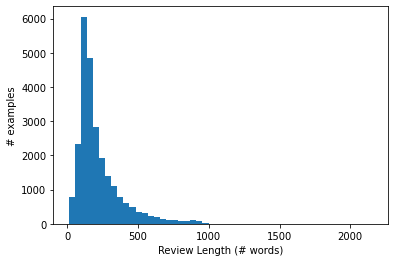

In [12]:
seq_lens = [len(seq) for seq in sequences]

plt.hist(seq_lens, bins=50)
plt.ylabel('# examples')
plt.xlabel('Review Length (# words)')
plt.show()

In [0]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) # (N, max_len)

In [17]:
x_train[0]

array([   1,   60, 2075, 1557,  731,   30,  587,    4, 2361, 2453,   19,
         10,   51, 2797,   11,    8,  281,    3,  795, 2210,   18, 2210,
          6, 2510,  741,    1, 9257,    4,    3, 1328, 1153,   61,   11,
        214,   23,  201, 2443,   15,   23, 2305, 6103,  725,  407, 2546,
         35,   26,   11,    1,   61,    6,  811,    2,    1,  410,   56,
        429,  242,   10,    6,   40,    1,   60, 2797,   11,  107,   76,
        328,   14,    1,   18, 1871,    8,    6,  278,   11,    8,    6,
         20, 2210,    7,    1,  277,    4,  412, 6190,   38, 1274,   28,
        104,   59,    9,   77, 6432,    1,  725,   61,  939,    3,  271,
        495,    4, 2210,   11,    6,   30,   53,  810,  390,   44,   21,
         22,    3, 2210,  333,    8,    6,   87,  670,    5, 3127,   11,
        495,    4, 2210,   15,   10,  785,    1, 1315,    6,  546,    2,
       4346,   59,  405,   21,    3,  143,  277,    4,    1, 2325,   13,
         26, 4111,    5,   23, 7260, 6103, 1338,   

# Model Definition

- https://github.com/keras-team/keras/blob/3bda5520b787f84f687bb116c460f3aedada039b/examples/pretrained_word_embeddings.py

In [0]:
embeddings_dict = {}

with smart_open.open('http://nlp.stanford.edu/data/glove.6B.zip', 'rb') as fin:
  zfin = zipfile.ZipFile(fin)
  for line in zfin.open('glove.6B.50d.txt'):
    word, coefs = line.decode('utf-8').split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_dict[word] = coefs

In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = tf.keras.layers.Embedding(
                            num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
# train a 1D convnet with global maxpooling
model = tf.keras.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 532,257
Trainable params: 32,257
Non-trainable params: 500,000
_________________________________________________________________


# Training

In [24]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=10,
                    validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.4471 - accuracy: 0.7876 - val_loss: 0.4730 - val_accuracy: 0.7696
Epoch 2/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.3222 - accuracy: 0.8640 - val_loss: 0.7224 - val_accuracy: 0.6568
Epoch 3/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.2656 - accuracy: 0.8910 - val_loss: 0.4734 - val_accuracy: 0.7840
Epoch 4/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.2155 - accuracy: 0.9151 - val_loss: 0.2851 - val_accuracy: 0.8784
Epoch 5/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.1686 - accuracy: 0.9392 - val_loss: 0.4359 - val_accuracy: 0.8204
Epoch 6/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.1319 - accuracy: 0.9570 - val_loss: 0.5925 - val_accuracy: 0.7722
Epoch 7/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.0975 - accuracy: 0.9722 - val_loss: 0.5126 -

# Evaluate

In [0]:
reviews_test, y_test = get_data(train=False)
seq_test = tokenizer.texts_to_sequences(reviews_test)
x_test = tf.keras.preprocessing.sequence.pad_sequences(seq_test, maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
model.evaluate(x_test, y_test, batch_size=64)

391/391 [==============================] - 15s 37ms/step - loss: 0.6099 - accuracy: 0.8136


[0.6098830103874207, 0.8135600090026855]

## Analyze

In [0]:
test_preds = model.predict(x_test).reshape(-1)

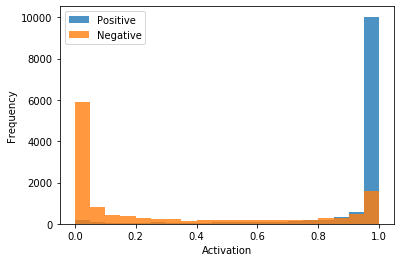

In [0]:
plt.hist(test_preds[y_test == 1], bins=20, alpha=0.8, label='Positive')
plt.hist(test_preds[y_test == 0], bins=20, alpha=0.8, label='Negative')
plt.xlabel('Activation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [0]:
sorted_preds = test_preds.argsort()

In [0]:
i = sorted_preds[0]
print(y_test[i], test_preds[i])
' '.join(reviews_test[i].split(' ')[:300])

0 0.0


'I had been avoiding this movie for sometime...because I viewed it as an unneccesary installment to a series that should have only had 2 parts. But, after reading some fairly favorable reviews...from some IMDB watchers...I spent $1.50 and rented it at my local video store. Need I go further...when I say....this was a buck-50 lost. This movie is one of the 10 worst movies I have ever seen. First off....I realize that noone wanted to see a 33 year old Macchio in this film.....But, why could\'nt they have had Miyagi read a letter or something from Daniel-san...maybe explaining what happened to Daniel...hell, they could have at least made a quick mention of daniel or something. But, no...and to compund the already bad script....they added those stupid monks...I thought monks take a vow of silence...guess these yapping monks don\'t take their vows seriously...hehehe. The training the girl went through in the movie was hurried and stupid...and the paramilitary group of young males....were a 

In [0]:
i = sorted_preds[-1]
print(y_test[i], test_preds[i])
' '.join(reviews_test[i].split(' ')[:300])

1 1.0


"One of my favorite movies of all times, have seen it three times already. It does a great job of summing up the Isrelai walks of life, Israeli humor, and seriousness, and much of the problems Israelis go through. Universal theme of wanting to be accepted, and be accepted for who you are. Good subtle humor, and it's the charisma of the characters, that makes this movie magic, and says a lot about Isrlaei culture, and the irnonicness, contradictions, and humor, with a great actor in it, Oshri Cohen. I highly recommend it to anyone, and it's a movie perfect for practically anyone, family movie, boyfriend/girlfriend movie, and also says apart from Israeli culture, wanting to be accepted, most of all, how important family is, with all its diversity and imperfections.Great great movie."

In [0]:
mediums = np.nonzero(test_preds.round(2) == 0.5)[0]
i = mediums[0]
print(y_test[i], test_preds[i])
' '.join(reviews_test[i].split(' ')[:300])

1 0.50354767


"I recently purchased this on DVD as I hadn't heard of it and like robert carlyle.Obviously this movie is not going to have Hollywood blockbuster special effects,in saying that though the special effects were decent enough,and the acting was fine also.I found the movie to be enjoyable and do not regret buying it at all,at almost 2 hours long it is just the right length for this type of movie.Do not expect thrilling explosive action from beginning to end though,it is a fairly well balanced movie with a decent enough storyline!"

In [0]:
# Worst false positive (it's actually negative but model says positive)
z_preds = test_preds.copy()
z_preds[y_test == 1] = 0
z_preds = z_preds.argsort()

In [0]:
i = z_preds[-2]
print(y_test[i], test_preds[i])
' '.join(reviews_test[i].split(' ')[:300])

0 0.9999996


'I really liked this quirky movie. The characters are not the bland beautiful people that show up in so many movies and on TV. It has a realistic edge, with a captivating story line. The main title sequence alone makes this movie fun to watch.'

In [0]:
# Worst false negative (it's actually positive but model says negative)
z_preds = test_preds.copy()
z_preds[y_test == 0] = 1
z_preds = z_preds.argsort()

In [0]:
i = z_preds[0]
print(y_test[i], test_preds[i])
' '.join(reviews_test[i].split(' ')[:300])

1 1.129508e-05


"To surmise, this film involves two actors (Caine and Moran) trying to con a gangster. The plot is flimsy at best as several plot holes occur throughout. However this normally shouldn't matter as the comedy should carry a film like this. There are some genuinely funny bits (mostly provided by Dylan Moran). However, other times, there are long melodramatic scenes that fail to add anything to the movie. Caine's character seemed overdone to me. Especially at the start, he continually quotes Shakespeare and acts like a pompous actor. One could say he was playing the part properly but the character seemed to me flat and unfunny. Overall I would say see only if a fan of the actors involved. Otherwise wait for video or tv."